In [1]:
!pip install lightfm kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831124 sha256=8a5352fdc1a09182735bc0092709a7dbd3927ead9e4226bf262c2b5617800e92
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as sp
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score

os.environ['KAGGLE_USERNAME'] = " "
os.environ['KAGGLE_KEY'] = " "

import kagglehub

print("Downloading new dataset (hernan4444/anime-recommendation-database-2020)...")
path = kagglehub.dataset_download("hernan4444/anime-recommendation-database-2020")
print("Path to dataset files:", path)
print(os.listdir(path))

Path to dataset files: /kaggle/input/anime-recommendation-database-2020
['html folder', 'watching_status.csv', 'rating_complete.csv', 'animelist.csv', 'anime.csv', 'anime_with_synopsis.csv']


In [ ]:
anime_df = pd.read_csv(os.path.join(path, 'anime.csv'))
rating_df = pd.read_csv(os.path.join(path, 'rating_complete.csv'))

print(f"Anime shape: {anime_df.shape}")
print(f"Ratings shape: {rating_df.shape}")
print("\nAnime Columns:\n", anime_df.columns.tolist())
anime_df.head(2)

Anime shape: (17562, 35)
Ratings shape: (57633278, 3)

Anime Columns:
 ['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name', 'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors', 'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity', 'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped', 'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [ ]:
anime_df = anime_df.rename(columns={'MAL_ID': 'anime_id', 'Name': 'name', 'English name': 'english_name'})

anime_df = anime_df.replace('Unknown', np.nan)

features_to_clean = ['Genres', 'Studios', 'Producers']
for col in features_to_clean:
    anime_df[col] = anime_df[col].fillna('')

anime_df['Score'] = pd.to_numeric(anime_df['Score'], errors='coerce')
anime_df['score_bin'] = pd.cut(anime_df['Score'], bins=[0, 6, 7.5, 9, 10], labels=['Low', 'Avg', 'High', 'Masterpiece'])

def create_feature_tags(row):
    tags = []
    tags.extend([f"Genre:{x.strip()}" for x in row['Genres'].split(',') if x])
    tags.extend([f"Studio:{x.strip()}" for x in row['Studios'].split(',') if x])
    if pd.notna(row['Source']): tags.append(f"Source:{row['Source']}")
    if pd.notna(row['Rating']): tags.append(f"Rating:{row['Rating']}")
    if pd.notna(row['score_bin']): tags.append(f"Quality:{row['score_bin']}")
    return tags

anime_df['feature_tags'] = anime_df.apply(create_feature_tags, axis=1)

print("Sample Feature Tags for 'Cowboy Bebop':")
print(anime_df.iloc[0]['feature_tags'])

Sample Feature Tags for 'Cowboy Bebop':
['Genre:Action', 'Genre:Adventure', 'Genre:Comedy', 'Genre:Drama', 'Genre:Sci-Fi', 'Genre:Space', 'Studio:Sunrise', 'Source:Original', 'Rating:R - 17+ (violence & profanity)', 'Quality:High']


In [ ]:
# --- FILTERING (Optional but recommended for speed) ---
# Keep only users who have rated at least 20 anime (reduces noise)
min_ratings_count = 20
user_counts = rating_df['user_id'].value_counts()
active_users = user_counts[user_counts >= min_ratings_count].index
rating_filtered = rating_df[rating_df['user_id'].isin(active_users)]

print(f"Filtered ratings shape: {rating_filtered.shape}")

all_users = rating_filtered['user_id'].unique()
all_items = anime_df['anime_id'].unique()

all_features = set()
for tags in anime_df['feature_tags']:
    all_features.update(tags)

dataset = Dataset()
dataset.fit(
    users=all_users,
    items=all_items,
    item_features=all_features
)

print(f"Mappings ready. Users: {dataset.interactions_shape()[0]}, Items: {dataset.interactions_shape()[1]}")

Filtered ratings shape: (57273055, 3)
Mappings ready. Users: 265263, Items: 17562


In [ ]:
import time

print("Building interaction matrix...")
start = time.time()

interactions_source = zip(
    rating_filtered['user_id'], 
    rating_filtered['anime_id'],
    rating_filtered['rating']
)
(interactions, weights) = dataset.build_interactions(interactions_source)

print(f"Interactions built in {time.time() - start:.2f} seconds.")

print("Building item features matrix...")
item_features_source = zip(
    anime_df['anime_id'], 
    anime_df['feature_tags']
)
item_features = dataset.build_item_features(item_features_source)

print("Matrices built!")
print(repr(interactions))
print(repr(item_features))

Building interaction matrix...
Interactions built in 93.09 seconds.
Building item features matrix...
Matrices built!
<COOrdinate sparse matrix of dtype 'int32'
	with 57273055 stored elements and shape (265263, 17562)>
<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 122345 stored elements and shape (17562, 18352)>


In [7]:
import os
print(os.cpu_count())

4


In [8]:
# # Initialize Model
# model = LightFM(loss='warp', 
#                 no_components=30, # Latent dimension (can increase to 50-100 for better accuracy)
#                 learning_rate=0.05, 
#                 random_state=42)

# print("Training model...")
# # Training
# model.fit(
#     interactions, 
#     item_features=item_features, 
#     epochs=10, # Increase to 20-30 for final version
#     num_threads=4,
#     verbose=True
# )
# print("Training Complete!")

In [9]:
# def recommend_for_user(user_id, model, dataset, anime_df, rating_df, k=5, verbose=0):
#     # 1. Get internal User ID
#     try:
#         user_internal_id = dataset.mapping()[0][user_id]
#     except KeyError:
#         print(f"User {user_id} not found in training data (Cold Start).")
#         return None

#     # --- 2. Identify Watched Items (External IDs) ---
#     # We grab the list of anime_ids this user has already interacted with
#     watched_ids = rating_df[rating_df['user_id'] == user_id]['anime_id'].unique()
    
#     # NEW: VERBOSE PRINTING (HISTORY)
#     if verbose:
#         print(f"\n--- User {user_id} Watched (History) ---")
#         watched_info = anime_df[anime_df['anime_id'].isin(watched_ids)]
#         cols_to_show = ['name', 'Genres', 'Studios', 'Rating']
#         display(watched_info[cols_to_show].head(10))
#         if len(watched_info) > 10:
#             print(f"... and {len(watched_info) - 10} more.")

#     # --- 3. Prepare for Prediction ---
#     n_users, n_items = dataset.interactions_shape()
#     item_indices = np.arange(n_items) # These are INTERNAL indices (0, 1, 2...)

#     # Get the mapping from External Anime ID -> Internal Index
#     # dataset.mapping()[2] returns {anime_id: internal_id}
#     external_to_internal_map = dataset.mapping()[2]

#     # Convert watched External IDs to Internal Indices
#     watched_internal_indices = [
#         external_to_internal_map[x] 
#         for x in watched_ids 
#         if x in external_to_internal_map
#     ]

#     # --- 4. Predict Scores ---
#     scores = model.predict(user_internal_id, item_indices, item_features=item_features)

#     # --- 5. MASK WATCHED ITEMS (The Fix) ---
#     # Set the score of already watched items to negative infinity.
#     # This ensures they appear at the very bottom of the sorted list.
#     scores[watched_internal_indices] = -np.inf

#     # --- 6. Rank items ---
#     # Create mapping from Internal Index -> External Anime ID
#     internal_to_external_map = {v: k for k, v in external_to_internal_map.items()}
    
#     # Get top K indices (now excluding watched items)
#     top_indices = np.argsort(-scores)[:k]
#     top_anime_ids = [internal_to_external_map[i] for i in top_indices]

#     # --- 7. Fetch details ---
#     recs = anime_df[anime_df['anime_id'].isin(top_anime_ids)]
    
#     # Sort recs by the order of top_anime_ids (to maintain rank)
#     recs = recs.set_index('anime_id').loc[top_anime_ids].reset_index()
    
#     final_recs = recs[['name', 'Genres', 'Studios', 'Rating']]

#     if verbose:
#         print(f"\n--- Recommendations for User {user_id} (New Items Only) ---")
#         display(final_recs)

#     return final_recs
# # Test with a user from the dataset
# # Note: We added 'rating_filtered' to the arguments!
# test_user_id = sorted(rating_filtered['user_id'].unique())[2]
# recs_test = recommend_for_user(test_user_id, model, dataset, anime_df, rating_filtered, k=10, verbose=1)

In [10]:
from lightfm.cross_validation import random_train_test_split

print("Splitting data into Train (80%) and Test (20%)...")
train_interactions, test_interactions = random_train_test_split(
    interactions, 
    test_percentage=0.2, 
    random_state=42
)

eval_model = LightFM(
    loss='warp', 
    no_components=30, 
    learning_rate=0.05, 
    random_state=42
)

print("Training evaluation model on TRAIN set (30 epochs)...")
eval_model.fit(
    train_interactions, 
    item_features=item_features, 
    epochs=30, 
    num_threads=4,
    verbose=True
)

Splitting data into Train (80%) and Test (20%)...
Training evaluation model on TRAIN set (30 epochs)...


Epoch: 100%|██████████| 30/30 [1:17:02<00:00, 154.10s/it]


In [ ]:
from tqdm import tqdm
import numpy as np
import scipy.sparse as sp

def manual_evaluation_arrays(model, train_matrix, test_matrix, item_features, k=10, sample_size=1000):
    """
    Returns raw numpy arrays of Precision, Recall, and NDCG for sampled users.
    """
    # --- Convert to CSR format ---
    if not isinstance(test_matrix, sp.csr_matrix):
        test_matrix = test_matrix.tocsr()
    if not isinstance(train_matrix, sp.csr_matrix):
        train_matrix = train_matrix.tocsr()

    n_users, n_items = test_matrix.shape
    test_user_counts = np.diff(test_matrix.indptr)
    test_active_users = np.where(test_user_counts > 0)[0]

    if len(test_active_users) > sample_size:
        rng = np.random.default_rng(42) 
        sampled_users = rng.choice(test_active_users, size=sample_size, replace=False)
    else:
        sampled_users = test_active_users

    print(f"Evaluating on {len(sampled_users)} sampled users...")

    precisions = []
    recalls = []
    ndcgs = []

    item_indices = np.arange(n_items, dtype=np.int32)
    discounts = 1.0 / np.log2(np.arange(k) + 2)

    for user_id in tqdm(sampled_users, desc="Evaluating"):
        t_start = test_matrix.indptr[user_id]
        t_end = test_matrix.indptr[user_id + 1]
        test_items = test_matrix.indices[t_start:t_end]

        if len(test_items) == 0: continue 

        tr_start = train_matrix.indptr[user_id]
        tr_end = train_matrix.indptr[user_id + 1]
        train_items = train_matrix.indices[tr_start:tr_end]

        user_ids_repeated = np.full(len(item_indices), user_id, dtype=np.int32)
        scores = model.predict(user_ids_repeated, item_indices, item_features=item_features)
        scores[train_items] = -np.inf

        top_k_unsorted = np.argpartition(-scores, k-1)[:k]
        top_k_sorted = top_k_unsorted[np.argsort(-scores[top_k_unsorted])]

        hits_mask = np.isin(top_k_sorted, test_items)
        hits_count = hits_mask.sum()

        precisions.append(hits_count / k)
        recalls.append(hits_count / len(test_items))

        dcg = np.sum(hits_mask * discounts[:len(hits_mask)])
        num_ideal_hits = min(k, len(test_items))
        idcg = np.sum(discounts[:num_ideal_hits])
        ndcgs.append(dcg / idcg if idcg > 0 else 0)

    return np.array(precisions), np.array(recalls), np.array(ndcgs)

In [31]:
SUBSET_SIZE = 1e5

precision_arr, recall_arr, ndcg_arr = manual_evaluation_arrays(
    eval_model, 
    train_interactions, 
    test_interactions, 
    item_features=item_features,
    k=10, 
    sample_size=int(SUBSET_SIZE)
)

print(f"\n--- Averages (Sample n={int(SUBSET_SIZE)}) ---")
print(f"Mean Precision@10: {precision_arr.mean():.4f}")
print(f"Mean Recall@10:    {recall_arr.mean():.4f}")
print(f"Mean NDCG@10:      {ndcg_arr.mean():.4f}")

Evaluating on 100000 sampled users...


Evaluating: 100%|██████████| 100000/100000 [11:38<00:00, 143.18it/s]



--- Averages (Sample n=100000) ---
Mean Precision@10: 0.4086
Mean Recall@10:    0.1408
Mean NDCG@10:      0.4521


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics_distribution(precision_arr, recall_arr, ndcg_arr):
    # Set style
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    metrics = [
        ("Precision@10", precision_arr, "blue"),
        ("Recall@10", recall_arr, "green"),
        ("NDCG@10", ndcg_arr, "purple")
    ]

    for i, (name, data, color) in enumerate(metrics):
        ax = axes[i]

        sns.histplot(data, bins=20, kde=True, color=color, ax=ax, alpha=0.6)

        mean_val = np.mean(data)
        median_val = np.median(data)
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
        ax.axvline(median_val, color='orange', linestyle='-', linewidth=2, label=f'Median: {median_val:.3f}')
        ax.set_title(f"{name} Distribution", fontsize=14, fontweight='bold')
        ax.set_xlabel("Score")
        ax.set_ylabel("Count of Users")
        ax.legend()

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


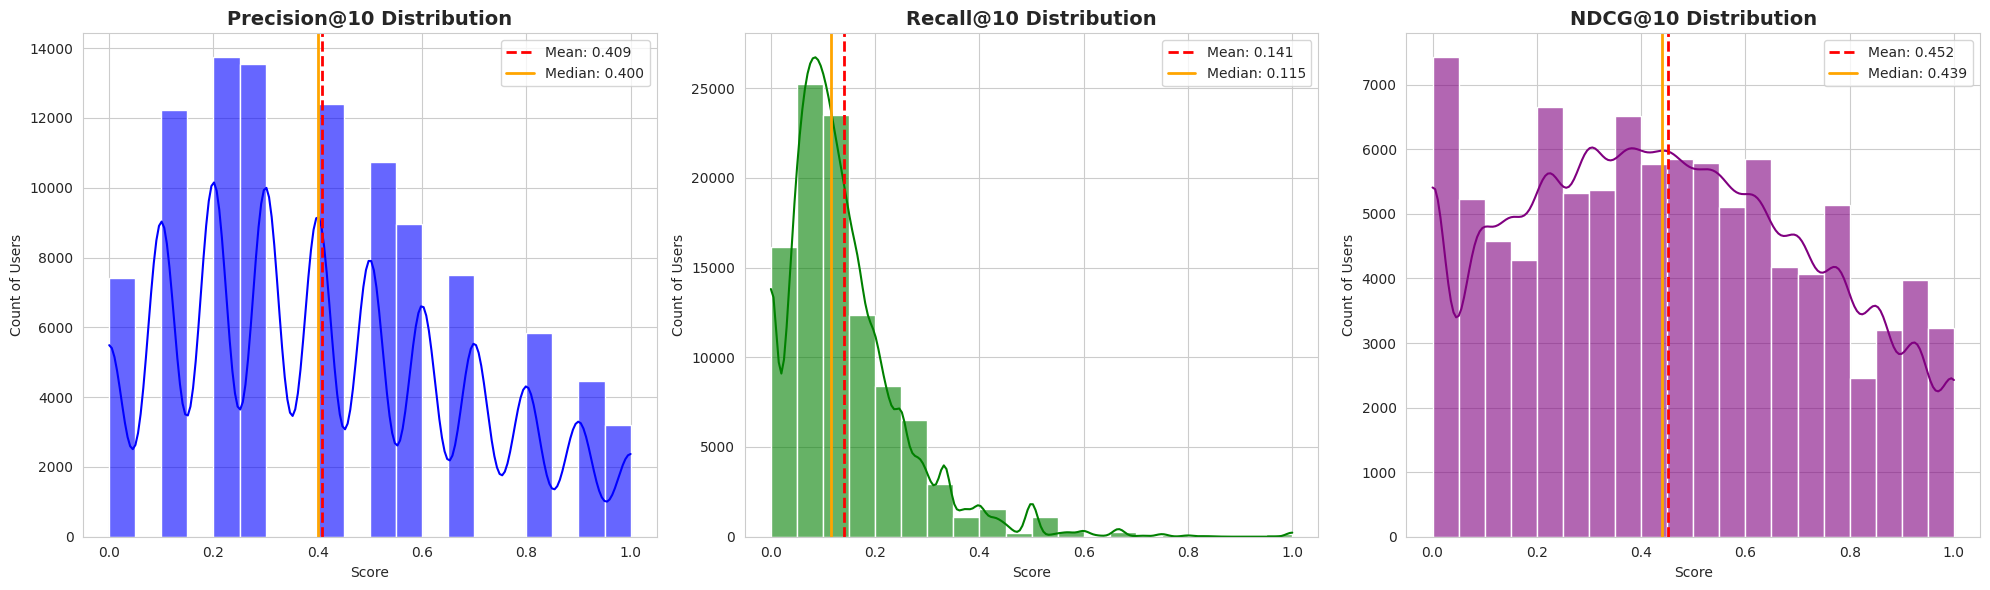

In [33]:
plot_metrics_distribution(precision_arr, recall_arr, ndcg_arr)

In [ ]:
import pickle

def save_recommender(filename, model, dataset, anime_df, item_features):
    print(f"Saving model to {filename}...")
    with open(filename, 'wb') as f:
        pickle.dump({
            'model': model,
            'dataset': dataset,
            'item_features': item_features,
            'anime_df': anime_df
        }, f)
    print("Saved successfully!")

save_recommender('anime_lightfm_model.pkl', eval_model, dataset, anime_df, item_features)

Saving model to anime_lightfm_model.pkl...
Saved successfully!


In [ ]:
def load_recommender(filename):
    print(f"Loading model from {filename}...")
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print("Model loaded.")
    return data['model'], data['dataset'], data['anime_df'], data['item_features']

loaded_model, loaded_dataset, loaded_anime, loaded_features = load_recommender('anime_lightfm_model.pkl')

Loading model from anime_lightfm_model.pkl...
Model loaded.


In [ ]:
def visualize_user_recs(user_id, model, dataset, anime_df, rating_df, k=10):
    """
    Generates recommendations and displays History vs. Recommendations side-by-side.
    """
    try:
        user_internal_id = dataset.mapping()[0][user_id]
    except KeyError:
        print(f"User {user_id} is Cold Start (no history in training).")
        return

    watched_ids = rating_df[rating_df['user_id'] == user_id]['anime_id'].unique()
    history_df = anime_df[anime_df['anime_id'].isin(watched_ids)].copy()

    user_ratings = rating_df[rating_df['user_id'] == user_id][['anime_id', 'rating']]
    history_df = history_df.merge(user_ratings, on='anime_id')
    history_df = history_df.sort_values('rating', ascending=False).head(k)

    n_items = dataset.interactions_shape()[1]
    item_indices = np.arange(n_items)

    scores = model.predict(user_internal_id, item_indices, item_features=loaded_features)

    item_map_ext_to_int = dataset.mapping()[2]
    watched_internal = [item_map_ext_to_int[x] for x in watched_ids if x in item_map_ext_to_int]
    scores[watched_internal] = -np.inf

    top_indices = np.argsort(-scores)[:k]
    item_map_int_to_ext = {v: k for k, v in item_map_ext_to_int.items()}
    rec_ids = [item_map_int_to_ext[i] for i in top_indices]

    rec_df = anime_df[anime_df['anime_id'].isin(rec_ids)].copy()
    rec_df = rec_df.set_index('anime_id').loc[rec_ids].reset_index()

    cols = ['name', 'Genres', 'Studios', 'Rating']

    print(f"\nUser ID: {user_id}")

    def style_df(df, title):
        return df[cols].style.set_caption(title).set_table_styles([
            {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('color', '#2c3e50')]}
        ])

    display(style_df(history_df, f"What User {user_id} Liked (History)"))
    display(style_df(rec_df, f"Top {k} Recommendations (Model Predictions)"))

In [44]:
sample_user = rating_df['user_id'].sample(18).iloc[0]

visualize_user_recs(sample_user, loaded_model, loaded_dataset, loaded_anime, rating_df, k=10)


User ID: 299703


,name,Genres,Studios,Rating
69,Fate/Zero,"Action, Supernatural, Magic, Fantasy",ufotable,R - 17+ (violence & profanity)
60,Hanasaku Iroha,"Slice of Life, Comedy, Drama",P.A. Works,PG-13 - Teens 13 or older
44,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",P.A. Works,PG-13 - Teens 13 or older
101,Shinsekai yori,"Drama, Horror, Mystery, Psychological, Sci-Fi, Supernatural",A-1 Pictures,R - 17+ (violence & profanity)
126,Choujigen Game Neptune The Animation,"Action, Comedy, Fantasy, Parody, Sci-Fi, Supernatural",David Production,PG-13 - Teens 13 or older
30,Toradora!,"Slice of Life, Comedy, Romance, School",J.C.Staff,PG-13 - Teens 13 or older
29,Kara no Kyoukai 3: Tsuukaku Zanryuu,"Action, Mystery, Supernatural, Drama, Thriller",ufotable,R+ - Mild Nudity
130,Kuroko no Basket 2nd Season,"Comedy, Sports, School, Shounen",Production I.G,PG-13 - Teens 13 or older
84,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,"Sci-Fi, Drama",White Fox,PG-13 - Teens 13 or older
78,Steins;Gate: Oukoubakko no Poriomania,"Sci-Fi, Comedy, Thriller",White Fox,PG-13 - Teens 13 or older


,name,Genres,Studios,Rating
0,Chuunibyou demo Koi ga Shitai!,"Slice of Life, Comedy, Drama, Romance, School",Kyoto Animation,PG-13 - Teens 13 or older
1,Netoge no Yome wa Onnanoko ja Nai to Omotta?,"Game, Comedy, Romance, Ecchi, School",Project No.9,PG-13 - Teens 13 or older
2,Ao no Kanata no Four Rhythm,"Sci-Fi, Sports, Drama, School",Gonzo,PG-13 - Teens 13 or older
3,Chuunibyou demo Koi ga Shitai! Ren,"Comedy, Drama, Romance, School, Slice of Life",Kyoto Animation,PG-13 - Teens 13 or older
4,Eromanga-sensei,"Comedy, Drama, Romance, Ecchi",A-1 Pictures,PG-13 - Teens 13 or older
5,Toaru Majutsu no Index II,"Action, Magic, Sci-Fi, Super Power",J.C.Staff,R - 17+ (violence & profanity)
6,Boku wa Tomodachi ga Sukunai Next,"Harem, Slice of Life, Comedy, Romance, School",AIC Build,R+ - Mild Nudity
7,Boku dake ga Inai Machi,"Mystery, Psychological, Supernatural, Seinen",A-1 Pictures,R - 17+ (violence & profanity)
8,Log Horizon,"Action, Game, Adventure, Magic, Fantasy",Satelight,PG-13 - Teens 13 or older
9,Clannad,"Comedy, Drama, Romance, School, Slice of Life, Supernatural",Kyoto Animation,PG-13 - Teens 13 or older


# Final model training and saving

In [45]:
final_model = LightFM(
    loss='warp', 
    no_components=30, 
    learning_rate=0.05, 
    random_state=42
)

In [46]:
final_model.fit(
    interactions, 
    item_features=item_features, 
    epochs=30,
    num_threads=4,
    verbose=True
)

Epoch: 100%|██████████| 30/30 [1:32:05<00:00, 184.18s/it]


In [47]:
def save_final_model(filename, model, dataset, anime_df, item_features):
    print(f"Saving final model to '{filename}'...")
    with open(filename, 'wb') as f:
        pickle.dump({
            'model': model,
            'dataset': dataset,
            'item_features': item_features,
            'anime_df': anime_df
        }, f)
    print("Saved successfully! You can now download this file.")


save_final_model('anime_lightfm_final.pkl', final_model, dataset, anime_df, item_features)

Saving final model to 'anime_lightfm_final.pkl'...
Saved successfully! You can now download this file.
